# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
import collections
import cv2                
import matplotlib.pyplot as plt   
%matplotlib inline  
import numpy as np
from glob import glob
import os

import PIL
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import random
import seaborn as sns
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms

from tqdm import tqdm

use_cuda = torch.cuda.is_available()

In [3]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


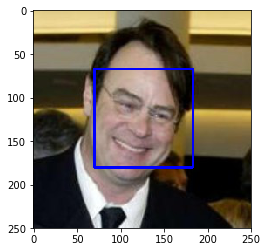

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [6]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_detected_in_human = 0
for human_face in tqdm(human_files_short):
    human_detected_in_human += int(face_detector(human_face))

human_detected_in_dog = 0
for dog_face in tqdm(dog_files_short):
    human_detected_in_dog += int(face_detector(dog_face))


100%|██████████| 100/100 [01:22<00:00,  3.87it/s]


## Answers to Question 1

In [8]:
print('human correctly detected in '+ str(human_detected_in_human) + '% of human images')
print('human incorrectly detected in '+ str(human_detected_in_dog) + '% of dog images')

human correctly detected in 98% of human images
human incorrectly detected in 17% of dog images


In [35]:
accuracy = (human_detected_in_human +(100 - human_detected_in_dog))/(len(human_files_short) + len(dog_files_short))
precision = human_detected_in_human/ (human_detected_in_human + human_detected_in_dog)
recall = human_detected_in_human/ len(human_files_short)
f1_score = 2 * (precision*recall) / (precision+recall)

print('Evaluation of Alt classifier')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1_score:', f1_score)

Evaluation of Alt classifier
Accuracy: 0.905
Precision: 0.8521739130434782
Recall: 0.98
F1_score: 0.9116279069767441


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [7]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.
face_cascade_default = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

def face_detector_with_cascade(img_path, cascade):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = cascade.detectMultiScale(gray)
    return len(faces) > 0

human_detected_in_human_default = 0
for human_face in tqdm(human_files_short):
    human_detected_in_human_default += int(face_detector_with_cascade(human_face, face_cascade_default))

human_detected_in_dog_default = 0
for dog_face in tqdm(dog_files_short):
    human_detected_in_dog_default += int(face_detector_with_cascade(dog_face, face_cascade_default))

100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


In [18]:
print('human correctly detected in '+ str(human_detected_in_human_default) + '% of human images using default face cascade')
print('human incorrectly detected in '+ str(human_detected_in_dog_default) + '% of dog images using default face cascade')

human correctly detected in 100% of human images using default face cascade
human incorrectly detected in 60% of dog images using default face cascade


In [37]:
accuracy = (human_detected_in_human_default +(100 - human_detected_in_dog_default))/(len(human_files_short) + len(dog_files_short))
precision = human_detected_in_human_default/ (human_detected_in_human_default + human_detected_in_dog_default)
recall = human_detected_in_human_default/ len(human_files_short)
f1_score = 2 * (precision*recall) / (precision+recall)

print('Evaluation of Default classifier')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Evaluation of Default classifier
Accuracy: 0.7
Precision: 0.625
Recall: 1.0
F1 score: 0.7692307692307693


## Comparing the alt and default frontal face classifiers

Comparing both the frontalface_alt classfier and the frontalface_default classifier. They both seem to have high and fairly similar recall scores 0.98 for the alt classifier and 1.0 for the default classifier. However, when comparing their precision and resulting F1 scores the alt classifier performs significantly better with a precision score of 0.85 compared to 0.63 for the default classifiers and an F1 score of 0.91 compared to the default classifiers 0.77, suggesting the alt classifier performs significantly better at distinguishing between dogs and humans. We choose to precede with the alt classifier due to the nature of this task, as it is crucial the algorithm we use is able to correctly distinguish between humans and dogs.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [18]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:37<00:00, 14892936.57it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [19]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    imgnet_normalisation = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    
    loader_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    imgnet_normalisation])
        
    image = ImageFile.Image.open(img_path)
    
    image = loader_transform(image).float()
    image = image.unsqueeze(0)
    
    use_cuda = torch.cuda.is_available()
    
    if use_cuda:
        image = image.to('cuda')
    
    VGG16.eval()
    y_pred = VGG16(image)
    index = torch.argmax(y_pred[0])
    
    return index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [20]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    VGG16_prediction = VGG16_predict(img_path)

    return 151 <= VGG16_prediction <= 268 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [21]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def dog_detection_assessment(humans,  dogs):
    
    dog_detected_in_dog = 0
    for dog in tqdm(dogs, position = 0, leave = True):
        dog_detected_in_dog += int(dog_detector(dog)) 
    
    dog_detected_in_human = 0
    for human in tqdm(humans,  position = 0, leave = True):
        dog_detected_in_human += int(dog_detector(human))
        
    return (dog_detected_in_human, dog_detected_in_dog)

human_preds_VGG, dog_preds_VGG = dog_detection_assessment(human_files_short,  dog_files_short)

100%|██████████| 100/100 [00:03<00:00, 29.41it/s]


## Answers to Question 2

In [22]:
print('Assessment of VGG16')
print('Dog detected incorrectly in human image in {}% of images'.format(human_preds_VGG))
print('Dog detected correctly in dog image in {}% of images'.format(dog_preds_VGG))

Assessment of VGG16
Dog detected incorrectly in human image in 0% of images
Dog detected correctly in dog image in 100% of images


In [38]:
accuracy = (dog_preds_VGG +(100 - human_preds_VGG))/(len(human_files_short) + len(dog_files_short))
precision = dog_preds_VGG/ (dog_preds_VGG + human_preds_VGG)
recall = dog_preds_VGG/ len(dog_files_short)
f1_score = 2 * (precision*recall) / (precision+recall)

print('Evaluation of VGG16')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Evaluation of VGG16
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [24]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
resnet50 = models.resnet50(pretrained=True)

if use_cuda:
    resnet50 = resnet50.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 41664415.24it/s]


In [25]:
def model_predict(img_path, model):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    imgnet_normalisation = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    
    loader_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    imgnet_normalisation])
        
    image = ImageFile.Image.open(img_path)
    
    image = loader_transform(image).float()
    image = image.unsqueeze(0)
    
    use_cuda = torch.cuda.is_available()
    
    if use_cuda:
        image = image.to('cuda')
    
    model.eval()
    y_pred = model(image)
    index = torch.argmax(y_pred[0])
    
    return index

def dog_detector_model(img_path, model):
    
    VGG16_prediction = model_predict(img_path, model)

    return 151 <= VGG16_prediction <= 268 # true/false

def dog_detection_assessment_model(humans,  dogs, model):
    
    dog_detected_in_human = 0
    for human in tqdm(humans,  position = 0, leave = True):
        dog_detected_in_human += int(dog_detector_model(human, model))

    dog_detected_in_dog = 0
    for dog in tqdm(dogs, position = 0, leave = True):
        dog_detected_in_dog += int(dog_detector_model(dog, model)) 
        
    return (dog_detected_in_human, dog_detected_in_dog)

In [26]:
human_preds_resnet50, dog_preds_resnet50 = dog_detection_assessment_model(human_files_short, dog_files_short, resnet50)


100%|██████████| 100/100 [00:03<00:00, 31.91it/s]


In [27]:
print('Assessment of resnet50')
print('Dog detected incorrectly in human image in {}% of images using ResNet-50'.format(human_preds_resnet50))
print('Dog detected correctly in dog image in {}% of images using ResNet-50'.format(dog_preds_resnet50))

Assessment of resnet50
Dog detected incorrectly in human image in 0% of images using ResNet-50
Dog detected correctly in dog image in 100% of images using ResNet-50


In [39]:
accuracy = (dog_preds_resnet50 +(100 - human_preds_resnet50))/(len(human_files_short) + len(dog_files_short))
precision = dog_preds_resnet50/ (dog_preds_resnet50 + human_preds_resnet50)
recall = dog_preds_resnet50/ len(dog_files_short)
f1_score = 2 * (precision*recall) / (precision+recall)

print('Evaluation of resnet50')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Evaluation of resnet50
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


Both models have perfect precision and recall!

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [4]:
## TODO: Write data loaders for training, validation, and test sets
# Specify appropriate transforms, and batch_sizes

#the normalisation values from img net
imgnet_normalisation = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.Resize(size = 256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       imgnet_normalisation])

valid_transforms = transforms.Compose([transforms.Resize(size = 256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           imgnet_normalisation])

#Using the same transforms for the validation and test set
test_transforms = valid_transforms

train_dataset = datasets.ImageFolder("/data/dog_images/train", transform = train_transforms)
valid_dataset = datasets.ImageFolder("/data/dog_images/valid", transform = valid_transforms)
test_dataset = datasets.ImageFolder("/data/dog_images/test", transform = test_transforms)

batch_size = 2
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True,
    num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, shuffle = False,
                                           num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False, 
                                          num_workers = num_workers)

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

The images are resized to 256 and then the centre is cropped to 224,  This was done because looking through the images it generally seemed the images of the dogs were in the centre (hence to focus on the dog and not the edges to reduce noise). 
In the training set a random horizontal flip was performed on the images with a probability of 0.5 this was done to prevent overfitting to the training set as the randomisation is between different epochs. This was not done to the validation and test data set to get a more accurate representation of the model on real world data "in the wild". Similarly a random rotation of 10 degrees was also added to the training set to introduce more variability. The images were normalised using the parameters from imgnet as frequently done in image classficiation tasks. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [47]:
number_of_classes = len(train_dataset.classes)

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        #Convolution layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        #Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        #Fully connected layer
        self.fc1 = nn.Linear(64*(28**2), 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, number_of_classes)
        
        #Dropout layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64*(28**2))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

A kernel size of 3 was used for effective edge/shape detection because anything less than 3 i.e. 2 would not have enough matrice cells to detect valid signals i.e. you need a matrix cell in the middle surrounded by other cells and there is little benefit in first inspection to using a kernel size of greater than 3.

A stride of 1 was used for the convolution layers along with padding of 1. This was because my intention with the convolution layers was to detect features and not to reduce dimensionality. I used the pooling layers to reduce dimensionality by using a 2*2 maxpool. 

Three convolution layers were used and this was sufficient to produce a model with accuracy greater than 10% as required by the task. Dropout was implemented with a probability of 0.25 to prevent overfitting during training.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [48]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [4]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        
        ###################
        # train the model #
        ###################
        train_loss = 0.0
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
            #clear the last gradient
            optimizer.zero_grad()
            
            output = model(data)
        
            #calculate loss
            loss = criterion(output, target)
            
            #backward propogate error
            loss.backward()
            
            # update model weights
            optimizer.step()
            
            # update training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss)) 
            
            if batch_idx % 1000 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss))
                   
        ######################    
        # validate the model #
        ######################
        valid_loss = 0.0
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
#             # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            #when you perform validation you do not need to calculate gradients for forward and backwar phase
            with torch.no_grad():
                #model output 
                output = model(data)
            
            #calculate loss
            loss = criterion(output, target)
            
            # update the validation loss
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
          
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [17]:
# train the model
model_scratch = train(15, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Batch: 1 	Training Loss: 4.876153
Epoch: 1 	Batch: 1001 	Training Loss: 4.887358
Epoch: 1 	Batch: 2001 	Training Loss: 4.875864
Epoch: 1 	Batch: 3001 	Training Loss: 4.839213
Epoch: 1 	Training Loss: 4.825745 	Validation Loss: 4.696113
Validation loss decreased (inf --> 4.696113). Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 5.110865
Epoch: 2 	Batch: 1001 	Training Loss: 4.658914
Epoch: 2 	Batch: 2001 	Training Loss: 4.613391
Epoch: 2 	Batch: 3001 	Training Loss: 4.586912
Epoch: 2 	Training Loss: 4.573503 	Validation Loss: 4.440106
Validation loss decreased (4.696113 --> 4.440106). Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 4.319608
Epoch: 3 	Batch: 1001 	Training Loss: 4.409310
Epoch: 3 	Batch: 2001 	Training Loss: 4.410902
Epoch: 3 	Batch: 3001 	Training Loss: 4.405005
Epoch: 3 	Training Loss: 4.401652 	Validation Loss: 4.368144
Validation loss decreased (4.440106 --> 4.368144). Saving model...
Epoch: 4 	Batch: 1 	Training Loss: 4.143685
Epoch: 4 	Batch: 1001 

In [21]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [22]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.869943


Test Accuracy: 12% (101/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [5]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [6]:
## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)
model_transfer

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 99897606.78it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
for param in model_transfer.parameters():
    param.requires_grad = False
    
number_of_classes = len(train_dataset.classes)

classifier = nn.Sequential(nn.Linear(25088, 4096),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 512),
                           nn.ReLU(),
                           nn.Dropout(0.5),
                           nn.Linear(512, number_of_classes))

# Rplace the original classifier with the dog breed classifier from above
model_transfer.classifier = classifier

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I decided to implement transfer learning on VGG16. This was informed by the fact that the model performed well in identifying dogs which suggests it contains useful high level features which can help with correctly classifying dog breeds.

The classifier part of the VGG16 model was replaced with a multilayer perceptron with a final output layer equal to the number of breeds in the dataset as required(133). A relu activation function was used between layers and a dropout of 0.5 was used to prevent overfitting.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [9]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
# train the model
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Batch: 1 	Training Loss: 4.574648
Epoch: 1 	Batch: 1001 	Training Loss: 4.887047
Epoch: 1 	Batch: 2001 	Training Loss: 4.784813
Epoch: 1 	Batch: 3001 	Training Loss: 4.720029
Epoch: 1 	Training Loss: 4.723354 	Validation Loss: 4.150079
Validation loss decreased (inf --> 4.150079). Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 4.894402
Epoch: 2 	Batch: 1001 	Training Loss: 4.411653
Epoch: 2 	Batch: 2001 	Training Loss: 4.360567
Epoch: 2 	Batch: 3001 	Training Loss: 4.306960
Epoch: 2 	Training Loss: 4.280995 	Validation Loss: 3.491674
Validation loss decreased (4.150079 --> 3.491674). Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 2.872397
Epoch: 3 	Batch: 1001 	Training Loss: 4.058217
Epoch: 3 	Batch: 2001 	Training Loss: 3.971124
Epoch: 3 	Batch: 3001 	Training Loss: 3.950652
Epoch: 3 	Training Loss: 3.940467 	Validation Loss: 3.025785
Validation loss decreased (3.491674 --> 3.025785). Saving model...
Epoch: 4 	Batch: 1 	Training Loss: 4.884682
Epoch: 4 	Batch: 1001 

In [10]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [13]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.814103


Test Accuracy: 75% (634/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [16]:
data_transfer = {'train':  train_dataset, 'valid':  valid_dataset, 'test':  test_dataset  }

### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path, model):
    # load the image and return the predicted breed
    
    image = PIL.Image.open(img_path)
    
    imgnet_normalisation = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    
    #
    loader_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    imgnet_normalisation])
    
    image = loader_transform(image).float()
    image = image.unsqueeze(0)
    
    use_cuda = torch.cuda.is_available()
    
    if use_cuda:
        image = image.to('cuda')
        
    model_prediction = model(image)
    
    pred_index = torch.argmax(model_prediction[0])
    
    pred_breed = class_names[pred_index]
    
    return pred_breed

def image_printer(img_path):
    
    img = cv2.imread(img_path)
        
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

## Intrabreed Results

In this section I will evaluate the differences in prediction accuracy for various breeds and examine the potential causes for this misclassification.

In [17]:
#Producing a dictionary with a given breed and it's predictions by the model

dog_test_folders = np.array(glob("/data/dog_images/test/*/"))

breed_name_array = []
breed_images_array = []
breed_predictions_array = []
accuracy_array = []

breed_dict = {}
for folder in tqdm(dog_test_folders, position = 0, leave = True):
    breed_name = folder.split('.')[1][:-1].replace("_", " ")
    breed_name_array.append(breed_name)
    
    file_string = folder + '*'
    images_in_folder = np.array(glob(file_string))
    breed_images_array.append(images_in_folder)
    
    breed_predictions = []
    for img_path in images_in_folder:
        prediction = predict_breed_transfer(img_path, model_transfer)
        breed_predictions.append(prediction)
        
    breed_predictions_array.append(breed_predictions)
    
    correct_predictions = 0
    
    for prediction in breed_predictions:
        if prediction == breed_name:
            correct_predictions += 1
            
    accuracy = correct_predictions/len(breed_predictions)
    accuracy_array.append(accuracy)
    
    breed_dict[breed_name] = {'predictions': breed_predictions, 'accuracy' : accuracy}

100%|██████████| 133/133 [00:32<00:00,  4.47it/s]


In [18]:
breed_dict

{'Mastiff': {'predictions': ['Mastiff',
   'Mastiff',
   'Mastiff',
   'Mastiff',
   'Bullmastiff',
   'Mastiff',
   'Bullmastiff'],
  'accuracy': 0.7142857142857143},
 'Doberman pinscher': {'predictions': ['German pinscher',
   'Beauceron',
   'German pinscher',
   'German pinscher',
   'German pinscher',
   'German pinscher'],
  'accuracy': 0.0},
 'Curly-coated retriever': {'predictions': ['Curly-coated retriever',
   'Curly-coated retriever',
   'Curly-coated retriever',
   'Curly-coated retriever',
   'Curly-coated retriever',
   'Greyhound',
   'Curly-coated retriever'],
  'accuracy': 0.8571428571428571},
 'Borzoi': {'predictions': ['Borzoi',
   'Collie',
   'Borzoi',
   'Borzoi',
   'Borzoi',
   'Borzoi',
   'Borzoi'],
  'accuracy': 0.8571428571428571},
 'Bichon frise': {'predictions': ['Maltese',
   'Bichon frise',
   'Bichon frise',
   'Bichon frise',
   'Bichon frise',
   'Bichon frise',
   'Bichon frise',
   'Bichon frise'],
  'accuracy': 0.875},
 'Chinese crested': {'predict

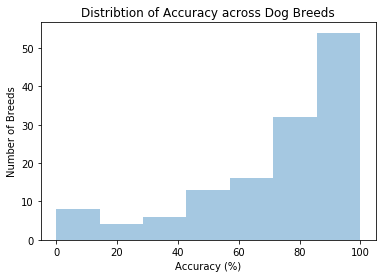

In [19]:
#Plotting the distribution of accuracies
accuracy_percentage_array = []

for accuracy in accuracy_array:
    percentage = accuracy*100
    accuracy_percentage_array.append(percentage)

ax = sns.distplot(accuracy_percentage_array, kde=False, rug=False);
ax.set(xlabel='Accuracy (%)', ylabel='Number of Breeds', title ='Distribtion of Accuracy across Dog Breeds')
ax;

In [20]:
#Detailed breakdown of the accuracies
accuracy_counter = collections.Counter(accuracy_array)
sorted(accuracy_counter.items(),key = lambda i: i[0])

[(0.0, 8),
 (0.25, 4),
 (0.3333333333333333, 3),
 (0.375, 1),
 (0.4, 2),
 (0.4444444444444444, 1),
 (0.5, 9),
 (0.5555555555555556, 2),
 (0.5714285714285714, 1),
 (0.6, 5),
 (0.625, 3),
 (0.6666666666666666, 8),
 (0.7142857142857143, 5),
 (0.75, 11),
 (0.8, 5),
 (0.8333333333333334, 5),
 (0.8571428571428571, 6),
 (0.875, 9),
 (0.8888888888888888, 2),
 (1.0, 43)]

### Breeds with 0% accuracy

Examining the breeds where the model did not return a single correct prediction i.e. 0% accuracy score, can give us an idea of the short comings of the model and if there are any patterns in how the model misclassifies images.

In [21]:
# Identifying the breeds with 0% accuracy and what breed the model misclassified the images to
misclassified_predictions = {}

for index, accuracy in enumerate(accuracy_array):
    if accuracy == 0:
        misclassified_predictions[breed_name_array[index]] = breed_predictions_array[index]
        
misclassified_predictions 

{'Doberman pinscher': ['German pinscher',
  'Beauceron',
  'German pinscher',
  'German pinscher',
  'German pinscher',
  'German pinscher'],
 'Cardigan welsh corgi': ['Canaan dog',
  'Pembroke welsh corgi',
  'Pembroke welsh corgi',
  'Norwegian lundehund',
  'Pembroke welsh corgi',
  'Pembroke welsh corgi',
  'Icelandic sheepdog'],
 'Irish red and white setter': ['Welsh springer spaniel',
  'Brittany',
  'Welsh springer spaniel',
  'Welsh springer spaniel'],
 'Glen of imaal terrier': ['Irish wolfhound',
  'Dandie dinmont terrier',
  'Chinese crested',
  'Irish wolfhound',
  'Briard'],
 'Smooth fox terrier': ['Bull terrier',
  'Italian greyhound',
  'Italian greyhound',
  'Italian greyhound'],
 'Plott': ['Great dane', 'Great dane', 'Great dane'],
 'Pointer': ['Great dane',
  'German shorthaired pointer',
  'Brittany',
  'German shorthaired pointer'],
 'German wirehaired pointer': ['English springer spaniel',
  'Briard',
  'Bouvier des flandres',
  'English springer spaniel',
  'Otterh

We proceed with the analysis by examining images of the first 2, 0% accuracy breeds i.e. the Doberman pinscher and the Cardigan welsh corgi, comparing the images to the most common misclassified breed i.e. German pinscher for the Doberman pinscher and the Pembroke welsh corgi for the Cardigan welsh corgi.

In [22]:
dog_breed_files = np.array(glob("/data/dog_images/train/*/"))

dog_breed_dic = {}

for folder in dog_breed_files:
    breed_name = folder.split('.')[1][:-1]
    dog_breed_dic[breed_name] = folder
    
def breed_img_printer(breed_name, img_number): 
    
    breed_name_format = breed_name.replace(" ", "_")
    
    dog_breed_folder = dog_breed_dic[breed_name_format]
    dog_breed_folder = dog_breed_folder + '*'

    dog_breed_files = np.array(glob(dog_breed_folder))

    random_breed_image = dog_breed_files[img_number]

    image_printer(random_breed_image)

Doberman Pinscher


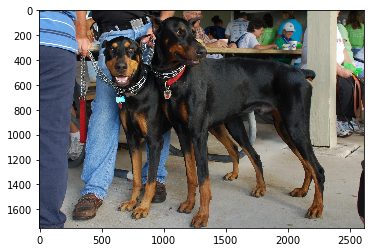

German Pinscher


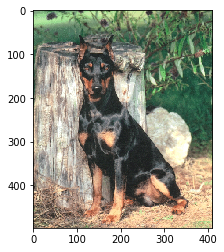

Cardigan Welsh corgi


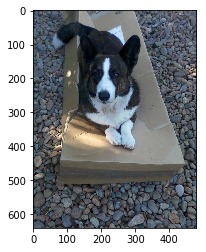

Pembroke Welsh Corgi


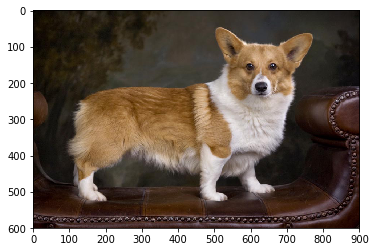

In [23]:
print('Doberman Pinscher')
breed_img_printer('Doberman pinscher', 1)
print('German Pinscher')
breed_img_printer('German pinscher', 0)
print('Cardigan Welsh corgi')
breed_img_printer('Cardigan welsh corgi', 2)
print('Pembroke Welsh Corgi')
breed_img_printer('Pembroke welsh corgi', 0)

In [24]:
print('The predictions for the German pinscher')
print(breed_dict['German pinscher'])
print('\n')
print('The predictions for the Pembroke welsh corgi')
print(breed_dict['Pembroke welsh corgi'])

The predictions for the German pinscher
{'predictions': ['German pinscher', 'Manchester terrier', 'German pinscher', 'German pinscher', 'German pinscher', 'German pinscher'], 'accuracy': 0.8333333333333334}


The predictions for the Pembroke welsh corgi
{'predictions': ['Pembroke welsh corgi', 'Pembroke welsh corgi', 'Norwegian lundehund', 'Norwegian lundehund', 'Pembroke welsh corgi', 'Pembroke welsh corgi', 'Pembroke welsh corgi'], 'accuracy': 0.7142857142857143}


In [25]:
# Find number of files
dog_train_folders = np.array(glob("/data/dog_images/train/*/"))

def training_size_finder(breed_string):
    
    breed_string_underscore = breed_string.replace(' ', '_')
    for folder_path in dog_train_folders:
        if breed_string_underscore in folder_path:
            
            number_of_files = len(np.array(glob(folder_path + '*')))
            print(breed_string,':' ,number_of_files)

In [26]:
print('Number of files in Training set')
training_size_finder('German pinscher')
training_size_finder('Doberman pinscher')
training_size_finder('Cardigan welsh corgi')
training_size_finder('Pembroke welsh corgi')

Number of files in Training set
German pinscher : 47
Doberman pinscher : 47
Cardigan welsh corgi : 53
Pembroke welsh corgi : 53


Examining the images confirms that the misclassifications are to breeds which look similar. In the case of the Doberman pinscher and the German pinscher, the Doberman pinscher is typically significantly larger. Whilst in the case of the Cardigan welsh corgi and the Pembroke welsh corgi. The Cardigan welsh corgi typically can have a coat in a wider array of colours i.e. merle and brindle are common colours for Cardigan welsh corgis but not for Pembroke welsh corgis. 

Notably in both cases the model did not misclassify German pinschers as Doberman pinschers or Pembroke welsh corgis as Cardigan welsh corgis. One reason for potential bias towards German pinschers and Pembroke welsh corgis can be an over representation in the training data. However, the output in the above cell confirms that there are exactly 47 images of both German and Doberman pinschers and 53 images each for the corgis. 

Increasing the size of the training data may lead to the model learning distinguishing characteristics of the specific breeds. Particularly if the images highlight the unique characteristics of a given breed compared to the breed it is frequently misclassified as i.e. more images where it is clear the Doberman Pinscher is larger and more images of Cardigan Welsh Corgi with brindle and merle coats. Examples of both of this can be seen in the above images.

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [12]:
dog_breed_files = np.array(glob("/data/dog_images/train/*/"))

dog_breed_dic = {}

for folder in dog_breed_files:
    breed_name = folder.split('.')[1][:-1]
    dog_breed_dic[breed_name] = folder
    
def random_breed_img_printer(breed_name): 
    
    breed_name_format = breed_name.replace(" ", "_")
    
    dog_breed_folder = dog_breed_dic[breed_name_format]
    dog_breed_folder = dog_breed_folder + '*'

    dog_breed_files = np.array(glob(dog_breed_folder))

    random_breed_image = random.choice(dog_breed_files)

    image_printer(random_breed_image)

In [73]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path, model):
    ## handle cases for a human face, dog, and neither
    
    dog_detected = dog_detector(img_path)
    
    human_detected = face_detector(img_path)
    
    if human_detected:
        
        print('hello, human')
        
        image_printer(img_path)
        
        predicted_breed = predict_breed_transfer(img_path, model_transfer)
        
        print('You look like a', predicted_breed)
        
        random_breed_img_printer(predicted_breed)
        
    elif dog_detected:
        
        image_printer(img_path)
        
        predicted_breed = predict_breed_transfer(img_path, model_transfer)
        
        print('This dog looks like a', predicted_breed)
        
    else:
        image_printer(img_path)
        print('Sorry I could not detected a human or dog in the above image') 

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

The output is better than expected, With the humans some resemblance is evident between the humans and the matched breeds. When trialling multiple images of friends and celebrities I noticed the model predicted quite a few Basenjis, Greyhounds and American staffordshire terriers. However, this exploration was not extensive. There may however be similar patterns like that across humans, as human faces may resemble particular breeds more than others. 

When it came to the dogs the model correctly identified the German shepherd dog. The model did not correctly identify the Rottweiler. This is because there is no Rottweiler in the dataset. However, it classed the Rottweiler as a Beauceron which is a dog breed that the Rottweiler closely resembles this is again a promising sign the model is learning feautures to classify the dog breed for a given image of a dog. Finally when an image of an Arcanine a pokemon which resembles a dog was passed to the model it sucessfuly did not identify a dog. This again is a promising sign as it shows the model can discern between actual pictures of dogs and creatures which superficially resemble dogs.

The model was also sucessful in not identifying humans or dogs in images without humans or dogs.

__Answer:__ (Three possible points for improvement)

1. One obvious point for improvement is to include more dog breeds in the dataset, there are well over 133 dog breeds and even popular breeds such as Rottweilers were not present in the dataset. Including more dog breeds would potentially decrease the accuracy of the model but maybe required. Another alternative to consider would be to remove some of the less well known dog breeds present in the dataset such as the Borzoi or the Otterhound and to replace them with more well known breeds such as the Rottweiler and the Pug.


2. The model was a simple modification using transfer learning of VGG16. One simple way to improve the model can be with hyperparameter tuning for the mlp that we attached to the end of VGG16. 


3. Another obvious way of potentially improving the model would be to train for more epochs. The validation loss was still improving in the 20th epoch and this suggests training for more epochs would possibly lead to an even lower validation loss and an improvement in the test accuracy. 

In [90]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

jay_image = 'images/jay_haran.jpg'
cummins_image = 'images/cummins.jpg'
cal_image = 'images/cal_newport.jpg'

human_files = [jay_image, cummins_image, cal_image]

gsd_image = 'images/german_shepherd.jpg'
rottie_image = 'images/rottweiler.jpg'
arcanine_image = 'images/arcanine.jpg'

dog_files = [gsd_image, rottie_image, arcanine_image]

london = 'images/london.jpg'
mountains = 'images/mountains.jpg'
rice = 'images/rice.jpg'

other_files = [london, mountains, rice]

hello, human


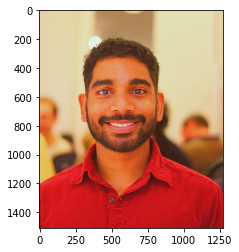

You look like a Basenji


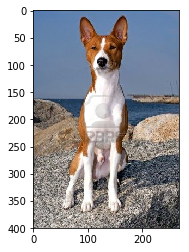

hello, human


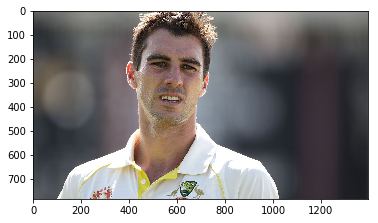

You look like a Basenji


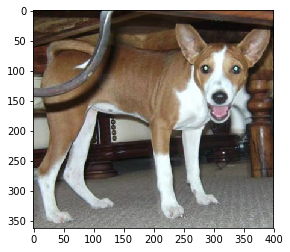

hello, human


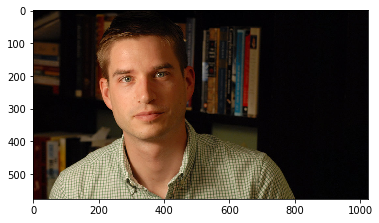

You look like a American staffordshire terrier


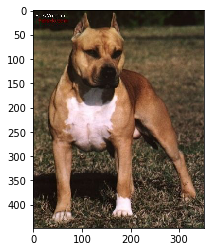

In [97]:
## suggested code, below
for file in human_files:
    run_app(file, model_transfer)

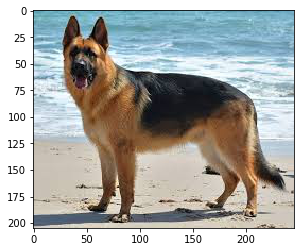

This dog looks like a German shepherd dog


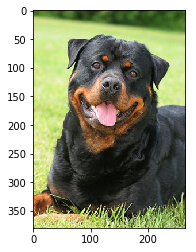

This dog looks like a Beauceron


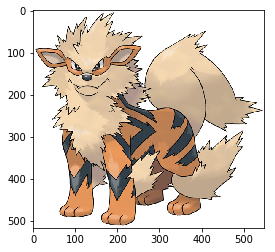

Sorry I could not detected a human or dog in the above image


In [98]:
for file in dog_files:
    run_app(file, model_transfer)

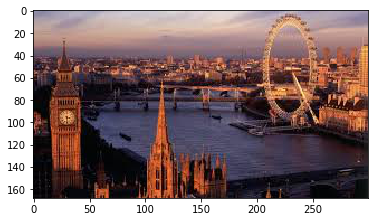

Sorry I could not detected a human or dog in the above image


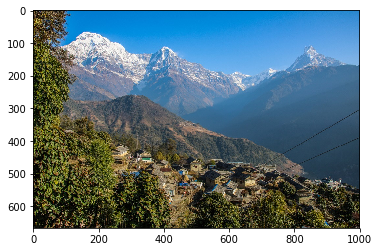

Sorry I could not detected a human or dog in the above image


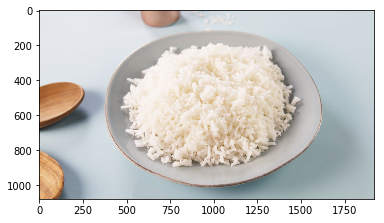

Sorry I could not detected a human or dog in the above image


In [99]:
for file in other_files:
    run_app(file, model_transfer)